- [Subset Selection](#6.5.1-Subset-Selection)
- [Forward Stagewise](#6.5.2-Forward)
- [Ridge Regression](#6.6.1-Ridge-Regression)
- [The Lasso](#6.6.2-The-Lasso)
- [Principal Components Regression](#6.7.1-Principal-Components-Regression)

# Linear Model Selection and Regularization (Chapter 6 - ISLR)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import scipy

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import glmnet as gln

from tqdm.notebook import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations

from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

/Users/yuany/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data: Hitters

In [2]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
hitters = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()

# Get the number of players  and the number of players with missing values
print('Hitters contains', len(hitters), 'players.')
num_missing = np.sum(hitters.isnull().any(axis=1))
print('We are missing data for', num_missing, 'players.')

# now remove the missing players for dataframe
hitters = hitters.dropna()
print('After removal Hitters contains', len(hitters), 'players.')
print('Shape=', hitters.shape)

hitters.index.name = 'Player'
hitters.info()

Hitters contains 263 players.
We are missing data for 0 players.
After removal Hitters contains 263 players.
Shape= (263, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [3]:
hitters.head()

                   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                          
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                    
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N    

Notice that columns League, Division and NewLeague are categorical. We will need to make dummy variables for these.

In [4]:
# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.info()
dummies.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB


              League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                  
-Alan Ashby          0         1           0           1            0   
-Alvin Davis         1         0           0           1            1   

              NewLeague_N  
Player                     
-Alan Ashby             1  
-Alvin Davis            0  

In [5]:
# Drop the columns for which we created dummy variables
df = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
# Define the new feature set with dummy variables.
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat          263 non-null int64
Hits           263 non-null int64
HmRun          263 non-null int64
Runs           263 non-null int64
RBI            263 non-null int64
Walks          263 non-null int64
Years          263 non-null int64
CAtBat         263 non-null int64
CHits          263 non-null int64
CHmRun         263 non-null int64
CRuns          263 non-null int64
CRBI           263 non-null int64
CWalks         263 non-null int64
PutOuts        263 non-null int64
Assists        263 non-null int64
Errors         263 non-null int64
Salary         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(1), int64(16), uint8(3)
memory usage: 37.8+ KB


In [6]:
df.head(2)

              AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                     
-Alan Ashby     315    81      7    24   38     39     14    3449    835   
-Alvin Davis    479   130     18    66   72     76      3    1624    457   

              CHmRun  CRuns  CRBI  CWalks  PutOuts  Assists  Errors  Salary  \
Player                                                                        
-Alan Ashby       69    321   414     375      632       43      10   475.0   
-Alvin Davis      63    224   266     263      880       82      14   480.0   

              League_N  Division_W  NewLeague_N  
Player                                           
-Alan Ashby          1           1            1  
-Alvin Davis         0           1            0  

### 6.5.1 Perform Best Subset Selection

Best subset selection forms every possible model from the predictors. It then compares models with the same nuber of predictors using RSS or $R^2$. Once the best model is picked for a given number of predictors, Models with different numbers of predictors are compared using one of the information criteria (AIC, BIC, Adj $R^2$), or by Cross-validation to select from among the models the model with the lowest TEST MSE.
In general, this method is not used because the computational cost is high. For a model with p-predictors, we must consider $2^p$ models. As such there is not a 'built-in' sklearn module for doing this. We will write a few helper functions to accomplish model selection.

In [7]:
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key= itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [8]:
# call our best_subsets function
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=19)

A Jupyter Widget

In [9]:
# The best two variable model has CRBI and Hits as predictors
models[1].params

const   -47.955902
Hits      3.300845
CRBI      0.689899
dtype: float64

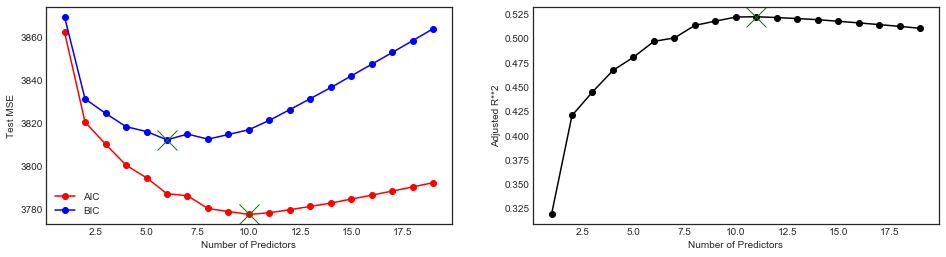

In [10]:
# Now that we have the best models for a given number of varaibles we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model for baseball player salary.
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

So all the estimates of the test error indicate we need a model with more than 5 predictors. The AIC and Adj $R^2$ indicate 10-11 predictors and the BIC statistic indcates 6 predictors.

In [11]:
# The Lowest BIC model has the following coeffecients
models[5].params

const          91.511798
AtBat          -1.868589
Hits            7.604398
Walks           3.697647
CRBI            0.643017
PutOuts         0.264308
Division_W   -122.951534
dtype: float64

### 6.5.2 Forward and Backward Stepwise Selection

As with Best-Subset Selection, we will need to custom write methods for performing Forward and Backward Stepwise selection. In sklearn there is a method called recusrsive feature elimination similar to Backward Stepwise Selection, but no methods I can find for Forward Selection.

The Forward Stepwise Selection algortihm sequentially adds predictors to the null model selecting the predictors that result in the lowest RSS for each added predictor. It then compares models with different features using Information Criteria or Cross-Validatation.

In [12]:
def forward_step_select(df, predictors, response, max_features=len(predictors)):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [13]:
# Call our forward step function
# set up inputs
predictors = list(df.columns)
predictors.remove('Salary')
# call forward_step_select
mods = forward_step_select(df,predictors,['Salary'],max_features=19)

In [14]:
mods[6][1].params # The seventh models features agree with regsubsets fwd result from lab.

const         109.787306
CRBI            0.853762
Hits            7.449877
PutOuts         0.253340
Division_W   -127.122393
AtBat          -1.958885
Walks           4.913140
CWalks         -0.305307
dtype: float64

Backwards subset selection (not implemented here) works very similary to forward except we remove features in the update_model function based on the feature which reduces the RSS the most. In the TEST MSE plot above we are moving from right to left reducing the number of predictors until we reach a minimum in the AIC or BIC curve.

In [15]:
# create an index to break the hitters dataframe into a train and test set that are roughly equal in size
np.random.seed(0)
index = np.random.choice([True, False], size=len(df))

# split the data into train and validation sets
df_train = df[index]
df_test = df[~index]

df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat          130 non-null int64
Hits           130 non-null int64
HmRun          130 non-null int64
Runs           130 non-null int64
RBI            130 non-null int64
Walks          130 non-null int64
Years          130 non-null int64
CAtBat         130 non-null int64
CHits          130 non-null int64
CHmRun         130 non-null int64
CRuns          130 non-null int64
CRBI           130 non-null int64
CWalks         130 non-null int64
PutOuts        130 non-null int64
Assists        130 non-null int64
Errors         130 non-null int64
Salary         130 non-null float64
League_N       130 non-null uint8
Division_W     130 non-null uint8
NewLeague_N    130 non-null uint8
dtypes: float64(1), int64(16), uint8(3)
memory usage: 18.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, -Alvin Davis to -Willie Upshaw
Data columns (total 20 columns):
AtBat       

In [16]:
# Construct the full dataset for Ridge and Lasso regularization paths
y = df.Salary

X = df.drop(['Salary'], axis=1).astype('float64')

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null float64
Division_W     263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(19)
memory usage: 41.1+ KB


In [17]:
X.head(2)

              AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat  CHits  \
Player                                                                       
-Alan Ashby   315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0  835.0   
-Alvin Davis  479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0  457.0   

              CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  Errors  \
Player                                                                 
-Alan Ashby     69.0  321.0  414.0   375.0    632.0     43.0    10.0   
-Alvin Davis    63.0  224.0  266.0   263.0    880.0     82.0    14.0   

              League_N  Division_W  NewLeague_N  
Player                                           
-Alan Ashby        1.0         1.0          1.0  
-Alvin Davis       0.0         1.0          0.0  

#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [18]:
X_train = pd.read_csv('data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('data/Hitters_y_test.csv', index_col=0)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, -Darryl Strawberry to -Mike Heath
Data columns (total 19 columns):
AtBat         131 non-null int64
Hits          131 non-null int64
HmRun         131 non-null int64
Runs          131 non-null int64
RBI           131 non-null int64
Walks         131 non-null int64
Years         131 non-null int64
CAtBat        131 non-null int64
CHits         131 non-null int64
CHmRun        131 non-null int64
CRuns         131 non-null int64
CRBI          131 non-null int64
CWalks        131 non-null int64
LeagueN       131 non-null int64
DivisionW     131 non-null int64
PutOuts       131 non-null int64
Assists       131 non-null int64
Errors        131 non-null int64
NewLeagueN    131 non-null int64
dtypes: int64(19)
memory usage: 20.5+ KB


In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat         132 non-null int64
Hits          132 non-null int64
HmRun         132 non-null int64
Runs          132 non-null int64
RBI           132 non-null int64
Walks         132 non-null int64
Years         132 non-null int64
CAtBat        132 non-null int64
CHits         132 non-null int64
CHmRun        132 non-null int64
CRuns         132 non-null int64
CRBI          132 non-null int64
CWalks        132 non-null int64
LeagueN       132 non-null int64
DivisionW     132 non-null int64
PutOuts       132 non-null int64
Assists       132 non-null int64
Errors        132 non-null int64
NewLeagueN    132 non-null int64
dtypes: int64(19)
memory usage: 20.6+ KB


### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

For the __glmnet() function in R__ the penalty is defined as:
### $$ \lambda\bigg(\frac{1}{2}(1−\alpha)|\beta|^2_2 \ +\ \alpha|\beta|_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.html)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above penalty to
### $$ \frac{1}{2}\lambda |\beta|^2_2 $$
The __sklearn Ridge()__ function has the standard L2 penalty:
### $$ \lambda |\beta|^2_2 $$


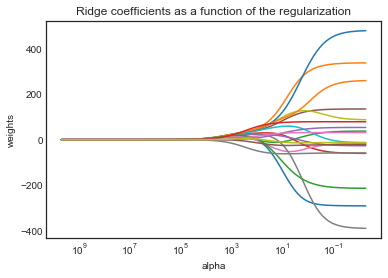

In [21]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [22]:
ridge2 = Ridge(alpha=4)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

99830.762063054848

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [23]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

#### Compute the regularization path using RidgeCV

In [24]:
ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


RidgeCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='mean_squared_error', store_cv_values=False)

In [25]:
ridgecv.alpha_

115.50648500415789

In [26]:
# % The CV optimal alpha leads to the smallest mean square error.
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

97384.929591725886

In [27]:
# % Show the regression coefficients.
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

### python-glmnet (update 2016-08-29)
This relatively new module is a wrapper for the fortran library used in the R package `glmnet`. It gives mostly the exact same results as described in the book. However, the `predict()` method does not give you the regression *coefficients* for lambda values not in the lambda_path. It only returns the predicted values.
https://github.com/civisanalytics/python-glmnet

In [28]:
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
      random_state=None, scoring=None, standardize=True, tol=1e-07,
      upper_limits=inf, verbose=False)

#### Lambda 11498

In [29]:
ridge3.lambda_path_[49]

11497.569953977356

In [30]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))

Intercept: 407.356


In [31]:
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)

AtBat          0.037
Hits           0.138
HmRun          0.525
Runs           0.231
RBI            0.240
Walks          0.290
Years          1.108
CAtBat         0.003
CHits          0.012
CHmRun         0.088
CRuns          0.023
CRBI           0.024
CWalks         0.025
PutOuts        0.016
Assists        0.003
Errors        -0.021
League_N       0.085
Division_W    -6.215
NewLeague_N    0.301
dtype: float64

In [32]:
np.sqrt(np.sum(ridge3.coef_path_[:,49]**2))

6.3606122865384505

#### Lambda 705

In [33]:
ridge3.lambda_path_[59]

705.48023107186452

In [34]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[59]))

Intercept: 54.325


In [35]:
pd.Series(np.round(ridge3.coef_path_[:,59], decimals=3), index=X.columns)

AtBat           0.112
Hits            0.656
HmRun           1.180
Runs            0.938
RBI             0.847
Walks           1.320
Years           2.596
CAtBat          0.011
CHits           0.047
CHmRun          0.338
CRuns           0.094
CRBI            0.098
CWalks          0.072
PutOuts         0.119
Assists         0.016
Errors         -0.704
League_N       13.684
Division_W    -54.659
NewLeague_N     8.612
dtype: float64

In [36]:
np.sqrt(np.sum(ridge3.coef_path_[:,59]**2))

57.11003436702412

#### Fit model using just the training set.

In [37]:
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.as_matrix().ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
      random_state=None, scoring='mean_squared_error', standardize=True,
      tol=1e-12, upper_limits=inf, verbose=False)

In [38]:
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
mean_squared_error(y_test.as_matrix().ravel(), pred)

101036.83230892917

#### Lambda chosen by cross validation

In [39]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.as_matrix().ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
      random_state=None, scoring='mean_squared_error', standardize=True,
      tol=1e-07, upper_limits=inf, verbose=False)

In [40]:
# Lambda with best CV performance
ridge5.lambda_max_

589.1835375713938

In [41]:
# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
ridge5.lambda_best_

array([ 15289.45544956])

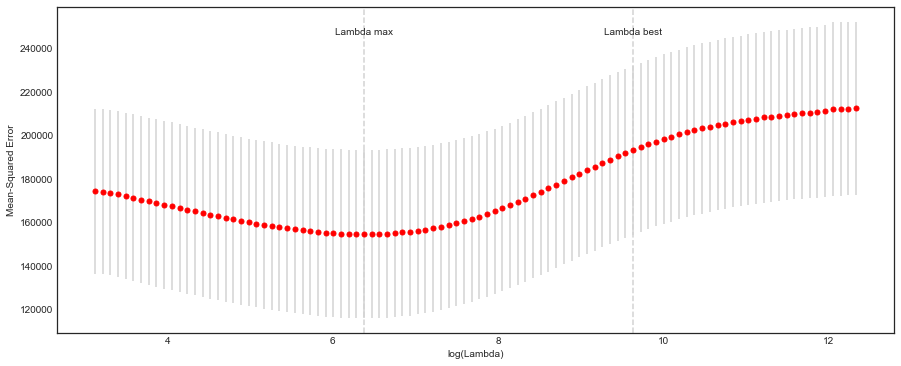

In [42]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capthick=2)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [43]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
mean_squared_error(y_test, pred)

98403.243550115149

#### Fit model to full data set

In [44]:
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge6.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
      random_state=None, scoring='mean_squared_error', standardize=True,
      tol=1e-07, upper_limits=inf, verbose=False)

In [45]:
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

AtBat           -0.681594
Hits             2.772311
HmRun           -1.365704
Runs             1.014812
RBI              0.713030
Walks            3.378558
Years           -9.066826
CAtBat          -0.001200
CHits            0.136102
CHmRun           0.697992
CRuns            0.295890
CRBI             0.257072
CWalks          -0.278966
PutOuts          0.263887
Assists          0.169878
Errors          -3.685656
League_N        53.209503
Division_W    -122.834334
NewLeague_N    -18.102528
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

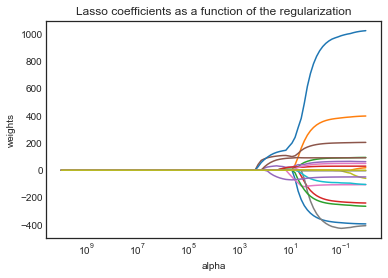

In [46]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [47]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.as_matrix().ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [48]:
lassocv.alpha_

30.01382256446427

In [49]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696963

In [50]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

### python-glmnet

In [51]:
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error')
lasso2.fit(X_train, y_train.as_matrix().ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
      random_state=None, scoring='mean_squared_error', standardize=True,
      tol=1e-07, upper_limits=inf, verbose=False)

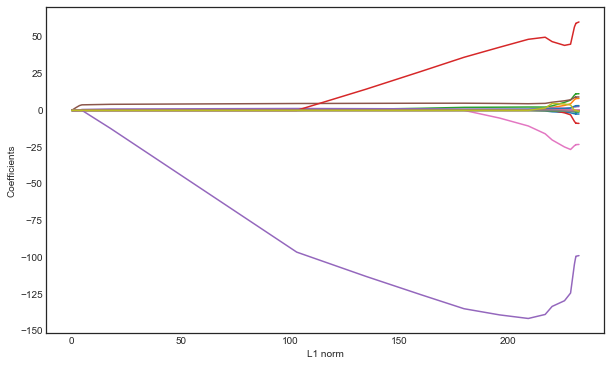

In [52]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

#### Let glmnet() create a grid to use in CV

In [53]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.as_matrix().ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True, lambda_path=None,
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
      random_state=None, scoring='mean_squared_error', standardize=True,
      tol=1e-07, upper_limits=inf, verbose=False)

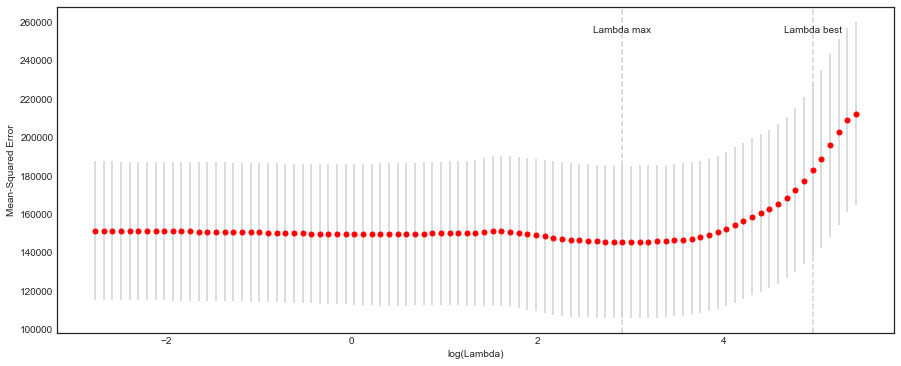

In [54]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capthick=2)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [55]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
mean_squared_error(y_test, pred)

100859.56269553718

#### Fit model on full dataset

In [56]:
lasso4 = gln.ElasticNet(alpha=1, scoring='mean_squared_error')
lasso4.fit(X, y)

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True, lambda_path=None,
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
      random_state=None, scoring='mean_squared_error', standardize=True,
      tol=1e-07, upper_limits=inf, verbose=False)

In [57]:
# These are not really close to the ones in the book.
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

AtBat           0.000000
Hits            1.777209
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           2.091407
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.000000
CRuns           0.198182
CRBI            0.397071
CWalks          0.000000
PutOuts         0.193407
Assists         0.000000
Errors          0.000000
League_N        0.000000
Division_W    -84.307058
NewLeague_N     0.000000
dtype: float64

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [58]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


          0         1         2         3         4         5
0  0.198290 -0.383784  0.088626  0.031967  0.028117 -0.070646
1  0.195861 -0.377271  0.074032  0.017982 -0.004652 -0.082240
2  0.204369 -0.237136 -0.216186 -0.235831  0.077660 -0.149646
3  0.198337 -0.377721 -0.017166 -0.049942 -0.038536 -0.136660
4  0.235174 -0.314531 -0.073085 -0.138985  0.024299 -0.111675

The above loadings are the same as in R.

In [59]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


          0         1         2         3         4         5
0 -0.009649  1.870522  1.265145 -0.935481  1.109636  1.211972
1  0.411434 -2.429422 -0.909193 -0.264212  1.232031  1.826617
2  3.466822  0.825947  0.555469 -1.616726 -0.857488 -1.028712
3 -2.558317 -0.230984  0.519642 -2.176251 -0.820301  1.491696
4  1.027702 -1.573537  1.331382  3.494004  0.983427  0.513675

The above principal components are the same as in R.

In [60]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.31,  60.15,  70.84,  79.03,  84.29,  88.63,  92.26,  94.96,
        96.28,  97.25,  97.97,  98.64,  99.14,  99.46,  99.73,  99.88,
        99.95,  99.98,  99.99])

/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


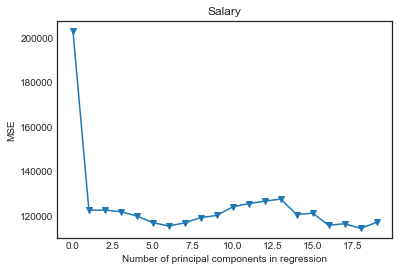

In [61]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [62]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

#### Fitting PCA with training data

/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


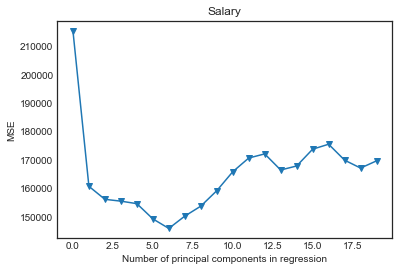

In [63]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [64]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

96320.020782503241

This test error is even smaller than best models of Ridge and Lasso.